<a href="https://colab.research.google.com/github/hazelkozlu/CoreDemo/blob/master/makalemobilenetson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#google drive bağlantısı için
from  google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Veri yolu ve parametreleri

train_data_dir = 'TezVeriSeti/train'
test_data_dir = 'TezVeriSeti/valid'
img_width, img_height = 224, 224   # MobileNetV2 giriş boyutu
batch_size = 32
epochs = 15  # Increase the number of epochs
num_classes = 4   # Toplam sınıf sayısı

# Veri artırma ve ön işleme
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,        # More rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# MobileNetV2 modelini yükleyin (weights='imagenet' ile önceden eğitilmiş ağırlıkları yükle)
base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Transfer Öğrenme yaparak yeni sınıflandırma katmanlarını ekleyin
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Increase the number of units
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),  # Add another Dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Modeli derleme ve öğrenme oranı düşürme
initial_learning_rate = 0.01
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * 0.9 ** epoch)
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model eğitimi
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[lr_schedule]
)


Found 958 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Epoch 1/15
30/30 [==============================] - 81s 2s/step - loss: 1.1174 - accuracy: 0.5846 - val_loss: 3.3194 - val_accuracy: 0.4990 - lr: 0.0100
Epoch 2/15
30/30 [==============================] - 67s 2s/step - loss: 0.6711 - accuracy: 0.7234 - val_loss: 0.5755 - val_accuracy: 0.7760 - lr: 0.0090
Epoch 3/15
30/30 [==============================] - 78s 3s/step - loss: 0.5880 - accuracy: 0.7578 - val_loss: 0.4172 - val_accuracy: 0.8156 - lr: 0.0081
Epoch 4/15
30/30 [==============================] - 75s 3s/step - loss: 0.4816 - accuracy: 0.8121 - val_loss: 0.5138 - val_accuracy: 0.8042 - lr: 0.0073
Epoch 5/15
30/30 [==============================] - 63s 2s/step - loss: 0.5103 - accuracy: 0.8079 - val_loss: 0.3515 - val_accuracy: 0.8604 - lr: 0.0066
Epoch 6/15
30/30 [==============================] - 76s 3s/step - loss: 0.4469 - accuracy: 0.8278 - val_loss: 0.3670 - val_accuracy: 0.8406 - lr: 0.0059


In [14]:
# Modeli değerlendirme
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Modeli kaydetme
model.save("mobilnetv2.h5")
print("Model başarıyla kaydedildi.")

# Yeni görüntüleri tahmin etme
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_leaf_disease(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Tahmin
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction[0])   # En yüksek olasılığa sahip sınıfın dizini
    class_labels = train_generator.class_indices   # Sınıf etiketlerini alın
    class_label = list(class_labels.keys())[list(class_labels.values()).index(class_index)]   # Sınıf etiketini alın
    print(f"Tahmin: {class_label}, Olasılık: {prediction[0][class_index]}")

# Test için yeni bir görüntü tahmini
##test_image_path = 'TezVeriSeti/valid/yaprakdelen/delendog (1).png'
test_image_path = 'TezVeriSeti/test1/test - Kopya/IMG_20220703_130251-256 b1 (145).png'

predict_leaf_disease(test_image_path)

30/30 [==============================] - 31s 988ms/step - loss: 0.2956 - accuracy: 0.8854
Test Loss: 0.29556897282600403, Test Accuracy: 0.8854166865348816
Model başarıyla kaydedildi.
1/1 [==============================] - 1s 728ms/step
Tahmin: yaprakdelen, Olasılık: 0.958946704864502


In [11]:
# Diğer importlar...
from sklearn.metrics import confusion_matrix, classification_report


# Modeli değerlendirme
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Karışıklık matrisini elde etme
test_generator.reset()  # Test veri kümesini sıfırlayın
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Karışıklık matrisini oluşturma
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Karışıklık Matrisi:")
print(confusion_mtx)

# Sınıflandırma raporunu elde etme ve yazdırma
class_labels = list(test_generator.class_indices.keys())
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


30/30 [==============================] - 30s 990ms/step - loss: 0.2956 - accuracy: 0.8854
Test Loss: 0.29556897282600403, Test Accuracy: 0.8854166865348816
30/30 [==============================] - 31s 1s/step
Karışıklık Matrisi:
[[240   0   0   0]
 [  0 191   7  42]
 [  3   2 214  21]
 [  0  18  17 205]]
Sınıflandırma Raporu:
               precision    recall  f1-score   support

      kulleme       0.99      1.00      0.99       240
potasyumeksik       0.91      0.80      0.85       240
     saglikli       0.90      0.89      0.90       240
  yaprakdelen       0.76      0.85      0.81       240

     accuracy                           0.89       960
    macro avg       0.89      0.89      0.89       960
 weighted avg       0.89      0.89      0.89       960



30/30 [==============================] - 30s 1s/step - loss: 0.2956 - accuracy: 0.8854
Test Loss: 0.29556897282600403, Test Accuracy: 0.8854166865348816
30/30 [==============================] - 30s 1s/step


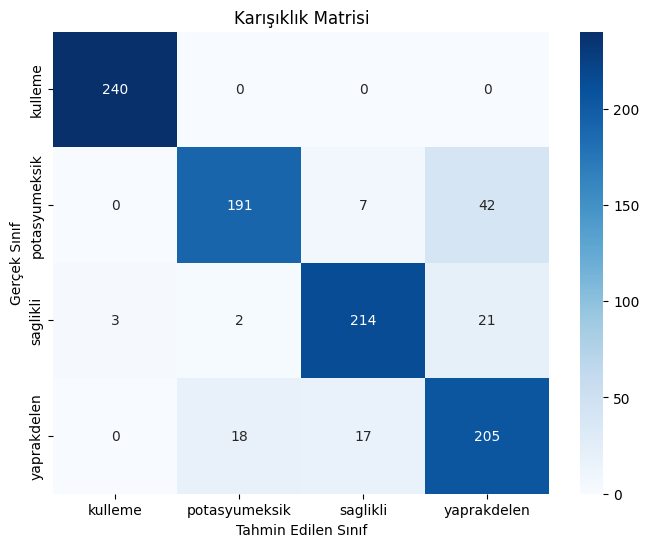

Sınıflandırma Raporu:
               precision    recall  f1-score   support

      kulleme       0.99      1.00      0.99       240
potasyumeksik       0.91      0.80      0.85       240
     saglikli       0.90      0.89      0.90       240
  yaprakdelen       0.76      0.85      0.81       240

     accuracy                           0.89       960
    macro avg       0.89      0.89      0.89       960
 weighted avg       0.89      0.89      0.89       960



In [12]:
# Diğer importlar...
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modeli değerlendirme
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Karışıklık matrisini elde etme
test_generator.reset()  # Test veri kümesini sıfırlayın
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Karışıklık matrisini oluşturma
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karışıklık Matrisi')
plt.show()

# Sınıflandırma raporunu elde etme ve yazdırma
class_labels = list(test_generator.class_indices.keys())
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
